# Generate mock PPDB/SSO data for PPDB tests

Author: Mario Juric <mjuric@uw.edu>

This notebook generates mock data for the following tables:
```
DiaSource
NearbySSO
SSSource
SSObject
mpc_orbits
```

To validate the assumptions for the "next generation" SSSource table, and enable bulk import tests.

The schemas for these tables are accurate, generated from `ppdb.yaml` using:

```
ssp-generate-dtypes ppdb.yaml DiaSource SSObject SSSource mpc_orbits current_identifications numbered_identifications NearbySSO > schema.py
```

(available in `mjuric/ssp-tools` repository). Much of the table contents is randomly generated, with the exception of various IDs to maintain the relationships between the tables.

Outline of the table generation strategy:

* Generate N nights worth of DiaSources
  * 10M/night == 300M records for 30 nights
  * We more/less randomly generate these, but try to keep ra/decs for the same visits within r=1.6deg from the visit center.
* Generate SSObject table by sampling a subset of `mpc_orbits` (rationale: we won't observe all asteroids)
* Generate the SSSource table:
  * Assume a small percentage of DiaSources are SSSources. The percentage is chosen to generate ~100M SSSources/yr (which Kurlander et al. 2025 predict using precise simulations)
  * Choose DiaSources preferentially around the ecliptic.
  * Fake the ephemerides using astrometry from DiaSources and by adding small shifts within 1"
* Generate NearbySSO table
  * Copy all SSSources that have a match
  * Add a small fraction (~10% of the SSSource length) that match at up to 5" radius. These mimic the nearby-but-not-physically-associated sources.
* Write all of these out in parquet.

In [1]:
import schema
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import os

In [2]:
def fill_zero_columns(arr):
    # fill columns that have only zeros with random data
    for name in arr.dtype.names:
        col = arr[name]

        # skip non-numeric fields
        if not np.issubdtype(col.dtype, np.number):
            continue

        # only fill columns that are zero everywhere
        if not np.all(col == 0):
            continue

        dt = col.dtype

        if np.issubdtype(dt, np.integer):
            col[:] = np.random.randint(0, 10000, size=len(col), dtype=dt)

        elif np.issubdtype(dt, np.floating):
            col[:] = np.random.standard_normal(len(col)).astype(dt)

        elif np.issubdtype(dt, np.bool_):
            col[:] = np.random.randint(0, 2, size=len(col)).astype(dt)

    return arr

import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def fill_zero_columns_mt(arr, *, max_workers=None):
    """
    Fill structured-array columns that are identically zero with random data, in-place, using threads.
    - ints:   uniform integers in [0, 10000)
    - floats: standard normal
    - bools:  random True/False
    """
    names = arr.dtype.names or ()
    if not names:
        return arr

    if max_workers is None:
        max_workers = min(32, (os.cpu_count() or 1))

    # Independent RNGs per worker (thread-safe and reproducible-per-run only if you fix entropy).
    ss = np.random.SeedSequence()
    child_seeds = ss.spawn(len(names))

    def _fill_one(i, name):
        col = arr[name]

        # skip non-numeric fields
        if not np.issubdtype(col.dtype, np.number):
            return

        # only fill columns that are zero everywhere
        if not np.all(col == 0):
            return

        dt = col.dtype
        rng = np.random.default_rng(child_seeds[i])

        if np.issubdtype(dt, np.integer):
            col[:] = rng.integers(0, 10000, size=col.shape, dtype=dt)

        elif np.issubdtype(dt, np.floating):
            col[:] = rng.standard_normal(size=col.shape).astype(dt, copy=False)

        elif np.issubdtype(dt, np.bool_):
            col[:] = rng.integers(0, 2, size=col.shape, dtype=np.uint8).astype(np.bool_, copy=False)

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        list(ex.map(lambda t: _fill_one(*t), enumerate(names)))

    return arr

def jitter_radec(ra, dec, r=1.0):
    ra, dec, tmax = map(np.deg2rad, (ra, dec, r))
    th = np.arccos(np.random.uniform(np.cos(tmax), 1.0, ra.size))
    ph = np.random.uniform(0.0, 2*np.pi, ra.size)
    sd, cd, sth, cth = np.sin(dec), np.cos(dec), np.sin(th), np.cos(th)
    dec = np.arcsin(sd*cth + cd*sth*np.cos(ph))
    ra  = (ra + np.arctan2(sth*np.sin(ph), cd*cth - sd*sth*np.cos(ph))) % (2*np.pi)
    return np.rad2deg(ra), np.rad2deg(dec), np.rad2deg(th)

import astropy.units as u
from astropy.coordinates import SkyCoord

def radec_to_galactic(ra, dec):
    c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")
    g = c.galactic
    return g.l.to_value(u.deg), g.b.to_value(u.deg)

def radec_to_ecl_iau76(ra, dec):
    ra, dec = np.deg2rad(ra), np.deg2rad(dec)
    ce, se = np.cos(np.deg2rad(84381.448/3600)), np.sin(np.deg2rad(84381.448/3600))
    x = np.cos(dec)*np.cos(ra)
    y = np.cos(dec)*np.sin(ra)
    z = np.sin(dec)
    lam = (np.rad2deg(np.arctan2(y*ce+z*se, x)) + 360) % 360
    bet = np.rad2deg(np.arcsin(-y*se+z*ce))
    return lam, bet



A column-store ndarray analog. Speeds things up by ~50% (depends on the machine).

In [3]:
from __future__ import annotations

from typing import Any, Dict, Mapping, Optional, Sequence, Union
import numpy as np

Key = Union[str, Sequence[str]]
RowSel = Union[int, slice, np.ndarray, Sequence[int], Sequence[bool]]


class ColumnarStruct:
    """
    Minimal structured-ndarray-like container with columnar storage.

    Supported:
      - obj["col"] -> 1D ndarray
      - obj[["c1","c2"]] -> ColumnarStruct (columns subset)
      - len(obj)
      - obj[row_sel] where row_sel is:
          int, slice, 1D integer indices, 1D boolean mask
      - obj["col"] = array_like (column assignment, with broadcast of scalars)
    """

    def __init__(self, cols: Mapping[str, Any], *, copy: bool = False, enforce_1d: bool = True):
        arrs: Dict[str, np.ndarray] = {}
        length: Optional[int] = None

        for name, col in cols.items():
            a = np.asarray(col)
            if enforce_1d and a.ndim != 1:
                raise ValueError(f"Column '{name}' must be 1D; got shape {a.shape}")
            if length is None:
                length = a.shape[0]
            elif a.shape[0] != length:
                raise ValueError(
                    f"All columns must have same length; '{name}' has {a.shape[0]} vs {length}"
                )
            arrs[str(name)] = a.copy() if copy else a

        if length is None:
            length = 0

        self._cols = arrs
        self._length = int(length)

    # ---- ndarray-ish surface area ----

    @property
    def dtype(self) -> np.dtype:
        fields = [(k, v.dtype) for k, v in self._cols.items()]
        return np.dtype(fields)

    @property
    def names(self) -> tuple[str, ...]:
        return tuple(self._cols.keys())

    def __len__(self) -> int:
        return self._length

    def __contains__(self, name: str) -> bool:
        return name in self._cols

    def __repr__(self) -> str:
        schema = ", ".join(f"{k}:{v.dtype}" for k, v in self._cols.items())
        return f"ColumnarStruct(len={len(self)}, cols=[{schema}])"

    # ---- core indexing ----

    def __getitem__(self, key: Union[Key, RowSel]) -> Any:
        # Column selection
        if isinstance(key, str):
            return self._cols[key]

        # Multi-column selection
        if isinstance(key, (list, tuple)) and key and all(isinstance(x, str) for x in key):
            missing = [c for c in key if c not in self._cols]
            if missing:
                raise KeyError(f"Missing columns: {missing}")
            return ColumnarStruct({c: self._cols[c] for c in key}, copy=False)

        # Row selection
        return self._take_rows(key)

    def __setitem__(self, key: str, value: Any) -> None:
        """
        Column assignment: obj["col"] = value

        Rules:
          - key must be a column name (string)
          - value may be:
              * scalar -> broadcast to length
              * 1D array-like of length len(self)
          - if column exists: assign into existing array (in-place) when possible
          - if column does not exist:
              * if len(self)==0, length becomes len(value) (if value is 1D)
              * else value must match len(self)
        """
        if not isinstance(key, str):
            raise TypeError("Column assignment only supports a string key, e.g. obj['col'] = ...")

        n = self._length

        # Normalize value
        v = np.asarray(value)

        # Scalar -> broadcast
        if v.ndim == 0:
            if key in self._cols:
                col = self._cols[key]
                col[...] = v.astype(col.dtype, copy=False) if col.dtype != v.dtype else v
            else:
                if n == 0:
                    raise ValueError(
                        "Cannot infer length from scalar when ColumnarStruct has len=0. "
                        "Initialize with columns or assign a 1D array first."
                    )
                self._cols[key] = np.empty(n, dtype=v.dtype)
                self._cols[key][...] = v
            return

        # Must be 1D for column assignment
        if v.ndim != 1:
            raise ValueError(f"Assigned column must be 1D or scalar; got shape {v.shape}")

        # Determine / validate length
        if n == 0 and key not in self._cols:
            # Allow first 1D assignment to define length
            self._length = int(v.shape[0])
            n = self._length
        elif v.shape[0] != n:
            raise ValueError(f"Length mismatch assigning '{key}': got {v.shape[0]} rows, expected {n}")

        # Assign into existing column when possible
        if key in self._cols:
            col = self._cols[key]
            # If dtype matches and sizes match, do in-place assignment
            try:
                col[...] = v
            except (TypeError, ValueError):
                # Fall back to safe cast if possible
                col[...] = v.astype(col.dtype, copy=False)
        else:
            # New column
            self._cols[key] = v

    def _take_rows(self, sel: RowSel) -> "ColumnarStruct":
        if isinstance(sel, int):
            if sel < 0:
                sel = self._length + sel
            if sel < 0 or sel >= self._length:
                raise IndexError("index out of range")
            return ColumnarStruct({k: v[sel:sel + 1] for k, v in self._cols.items()}, copy=False)

        if isinstance(sel, slice):
            return ColumnarStruct({k: v[sel] for k, v in self._cols.items()}, copy=False)

        a = np.asarray(sel)

        if a.dtype == np.bool_:
            if a.ndim != 1 or a.shape[0] != self._length:
                raise IndexError(f"Boolean mask must be 1D of length {self._length}")
            return ColumnarStruct({k: v[a] for k, v in self._cols.items()}, copy=False)

        if np.issubdtype(a.dtype, np.integer):
            if a.ndim != 1:
                raise IndexError("Index array must be 1D")
            return ColumnarStruct({k: v[a] for k, v in self._cols.items()}, copy=False)

        raise TypeError("Row selector must be int, slice, 1D integer indices, or 1D boolean mask")

    # ---- convenience ----

    def select(self, *names: str) -> "ColumnarStruct":
        return self[list(names)]

    def to_structured(self) -> np.ndarray:
        dt = self.dtype
        out = np.empty(self._length, dtype=dt)
        for name, col in self._cols.items():
            out[name] = col
        return out

    # ---- Jupyter / rich display ----

    def _preview_dataframe(self, max_rows: int = 10):
        import pandas as pd

        n = len(self)
        k = min(max_rows, n)
        data = {name: col[:k] for name, col in self._cols.items()}

        df = pd.DataFrame(data)
        if n > k:
            df = df.copy()
            df.attrs["__columnarstruct_truncated__"] = (k, n)
        return df

    def _repr_html_(self) -> str:
        try:
            df = self._preview_dataframe(max_rows=10)
        except Exception as e:
            return f"<pre>{self.__repr__()}\n\n[display error: {type(e).__name__}: {e}]</pre>"

        html = df._repr_html_()

        trunc = df.attrs.get("__columnarstruct_truncated__")
        if trunc:
            k, n = trunc
            footer = (
                f"<div style='margin-top:4px; color:#666; font-size:0.9em;'>"
                f"Showing first {k} of {n} rows</div>"
            )
            html = f"{html}{footer}"

        schema = ", ".join(f"{name}:{arr.dtype}" for name, arr in self._cols.items())
        header = (
            f"<div style='margin-bottom:6px;'>"
            f"<strong>ColumnarStruct</strong> "
            f"<span style='color:#666;'>(len={len(self)})</span><br/>"
            f"<span style='color:#666; font-size:0.9em;'>{schema}</span>"
            f"</div>"
        )
        return f"{header}{html}"

    def __array__(self, dtype=None) -> np.ndarray:
        """
        NumPy conversion hook.

        This makes np.asarray(ColumnarStruct) (and therefore pd.DataFrame(ColumnarStruct))
        produce a structured ndarray with fields matching columns.

        Note: this materializes a structured (AoS) copy of the current rows.
        """
        arr = self.to_structured()  # structured ndarray with named fields
        if dtype is not None:
            arr = arr.astype(dtype, copy=False)
        return arr

In [4]:
import numpy as np
from typing import Union

def columnar_empty(
    shape: int,
    dtype: Union[np.dtype, list[tuple[str, np.dtype]]],
) -> ColumnarStruct:
    """
    Create an uninitialized ColumnarStruct, analogous to np.empty.

    Parameters
    ----------
    shape : int
        Number of rows.
    dtype : structured dtype or list of (name, dtype)
        Column schema.

    Returns
    -------
    ColumnarStruct
    """
    dt = np.dtype(dtype)
    if dt.fields is None:
        raise TypeError("dtype must be a structured dtype")

    cols = {}
    for name, (subdtype, _) in dt.fields.items():
        cols[name] = np.empty(shape, dtype=subdtype)

    return ColumnarStruct(cols, copy=False)


In [5]:
def memmap_empty(path, shape, dtype, order="C"):
    """
    Create a file-backed, uninitialized ndarray (np.empty analog).

    Parameters
    ----------
    path : str or Path
        File path backing the memmap.
    shape : int or tuple of int
        Array shape.
    dtype : numpy dtype or dtype spec
        Array dtype.
    order : {"C", "F"}, optional
        Memory layout.

    Returns
    -------
    ndarray
        File-backed NumPy array.
    """
    mm = np.memmap(
        path,
        dtype=np.dtype(dtype),
        mode="w+",
        shape=shape,
        order=order,
    )
    return np.asarray(mm)

In [6]:
def structured_to_parquet(dia, path, *, batch_rows=1_000_000, compression="zstd",
                          use_dictionary=True, write_statistics=True):
    """
    Serialize a structured numpy array (possibly memmap) to a Parquet file in chunks.

    Parameters
    ----------
    dia : np.ndarray
        Structured array with dtype.names. Can be np.memmap.
    path : str | pathlib.Path
        Output parquet path.
    batch_rows : int
        Rows per write batch (and default row group size).
    compression : str | None
        Parquet compression (e.g., "zstd", "snappy", "gzip", None).
    use_dictionary : bool
        Enable dictionary encoding where beneficial.
    write_statistics : bool
        Write column statistics (can improve predicate pushdown; may add overhead).
    """
    import pyarrow as pa
    import pyarrow.parquet as pq

    if dia.dtype.names is None:
        raise TypeError("dia must be a structured array (dia.dtype.names is None).")

    print(f"{path}:")
    print(f"  Number of rows:          {len(dia)}")
    print(f"  Uncompressed size (GiB): {len(dia)*dia.dtype.itemsize / 1024**3:.1f}")

    n = len(dia)
    if n == 0:
        # Write an empty file with the right schema.
        arrays = [pa.array(dia[name]) for name in dia.dtype.names]
        table = pa.Table.from_arrays(arrays, names=list(dia.dtype.names))
        pq.write_table(table, path, compression=compression,
                       use_dictionary=use_dictionary, write_statistics=write_statistics)
        return

    writer = None
    try:
        for start in range(0, n, batch_rows):
            stop = min(start + batch_rows, n)
            chunk = dia[start:stop]  # works for memmap without loading everything

            arrays = [pa.array(chunk[name]) for name in chunk.dtype.names]
            table = pa.Table.from_arrays(arrays, names=list(chunk.dtype.names))

            if writer is None:
                writer = pq.ParquetWriter(
                    path, table.schema,
                    compression=compression,
                    use_dictionary=use_dictionary,
                    write_statistics=write_statistics,
                )

            writer.write_table(table, row_group_size=len(chunk))
    finally:
        if writer is not None:
            writer.close()

    print(f"  Compressed parquet (GB): {os.path.getsize(path)/1e9:.2f}")


In [7]:
mjd0 = 61041 # Jan 1, 2026
nnights = 60
visitsPerNight = 1000
diaPerVisit = 10_000

# The observed fraction of mpc_orbits catalog
frac_mpc = nnights/365.

# Fraction of sources that associate to SolSys objects
# Should be set so that the annual total is ~100M
frac_assoc = 0.03

# Fraction of SSOs (excluding those in frac_assoc) that
# fall within 5" of DiaSources. These will appear in
# NearbySSO but not in the SSSource table.
frac_near = frac_assoc/10.

diaPerNight = diaPerVisit * visitsPerNight

ndia = diaPerNight*nnights

# DiaSource

In [8]:
#dia = memmap_empty("diasource.dat", shape=(ndia,), dtype=schema.DiaSourceDtype)
#dia = np.empty(shape=(ndia,), dtype=schema.DiaSourceDtype)
dia = columnar_empty(shape=(ndia,), dtype=schema.DiaSourceDtype)

In [9]:
%%time
dia["midpointMjdTai"] = np.random.uniform(mjd0, mjd0 + nnights, ndia)
dia["midpointMjdTai"].sort()
dia["midpointMjdTai"] -= (dia["midpointMjdTai"] - dia["midpointMjdTai"].astype(int)) / 2.

dia["diaSourceId"] = np.arange(ndia)
dia["visit"] = dia["diaSourceId"] / diaPerVisit
vis_det = dia["visit"] * 1000 + dia["diaSourceId"] % 189
vis_det.sort()
vis_det -= dia["visit"] * 1000
dia["detector"] = vis_det

dia["diaObjectId"] = dia["diaSourceId"] / nnights

dia["ra"] = np.random.uniform(0, 360, size=len(dia))
dia["raErr"] = np.random.uniform(0, 0.2, size=len(dia))
dia["dec"] = np.random.uniform(-90, 90, size=len(dia))
dia["decErr"] = np.random.uniform(0, 0.2, size=len(dia))

ra, dec = hp.pix2ang(16, 3*(dia["visit"] % visitsPerNight), nest=True, lonlat=True)
ra, dec, _ = jitter_radec(ra, dec, 1.6)
dia["ra"], dia["dec"] = ra, dec

dia["apFlux"] = np.random.uniform(3.63, 912, size=len(dia)) # (15 .. 24th mag flux)
dia["apFluxErr"] = np.random.uniform(0.1, 0.6, size=len(dia))
dia["psfFlux"] = dia["apFlux"] + np.random.uniform(-0.5, 0.5, size=len(dia))
dia["psfFluxErr"] = dia["apFluxErr"] + np.random.uniform(-0.1, 0.1, size=len(dia))

fill_zero_columns_mt(dia)

print(len(dia))
#pd.DataFrame(dia[998:][:10])
dia[998:][:10]

600000000
CPU times: user 5min 47s, sys: 9min 58s, total: 15min 45s
Wall time: 2min 27s


,diaSourceId,visit,detector,diaObjectId,parentDiaSourceId,ssObjectReassocTimeMjdTai,midpointMjdTai,ra,raErr,dec,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail
0,998,0,18,16,3588,1.275734,61041.000048,45.200606,0.033131,1.187415,...,False,False,False,False,False,False,False,False,False,False
1,999,0,18,16,1756,1.295738,61041.000049,44.140990,0.122080,2.400285,...,False,False,False,False,False,False,False,False,False,False
2,1000,0,18,16,8205,-0.008088,61041.000049,45.810126,0.188911,3.147406,...,False,False,False,False,False,False,False,False,False,False
3,1001,0,18,16,4716,-0.536101,61041.000049,45.990930,0.084156,1.709514,...,False,False,False,False,False,False,False,False,False,False
4,1002,0,18,16,1095,1.250372,61041.000049,45.027474,0.046222,3.007876,...,False,False,False,False,False,False,False,False,False,False
5,1003,0,18,16,6844,-0.542535,61041.000049,43.770660,0.092570,3.128937,...,False,False,False,False,False,False,False,False,False,False
6,1004,0,18,16,2677,-0.689219,61041.000049,44.885887,0.183710,3.798136,...,False,False,False,False,False,False,False,False,False,False
7,1005,0,18,16,1378,0.635759,61041.000049,44.210495,0.091255,3.446791,...,False,False,False,False,False,False,False,False,False,False
8,1006,0,18,16,6326,-0.339079,61041.000049,44.805543,0.092243,1.741520,...,False,False,False,False,False,False,False,False,False,False
9,1007,0,19,16,4901,0.981957,61041.000049,44.407293,0.138107,3.717870,...,False,False,False,False,False,False,False,False,False,False


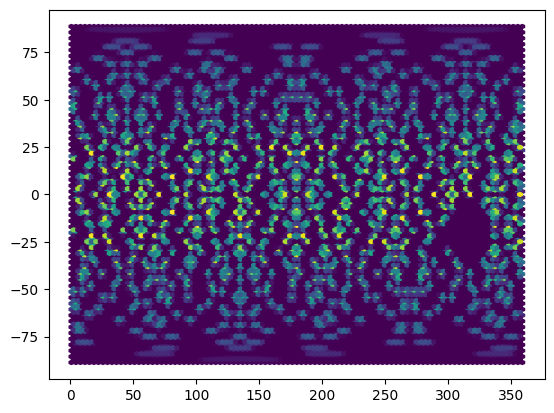

In [10]:
plt.hexbin(dia["ra"], dia["dec"]);

# mpc_orbits

In [11]:
mpc = pd.read_parquet("mpc_orbits.parquet", columns=["unpacked_primary_provisional_designation"])
nmpc = len(mpc)

# SSObject

In [12]:
%%time
# random subset
np.random.seed(42)
idx = np.random.permutation(nmpc)[:int(frac_mpc * nmpc)]

ssobject = columnar_empty(shape=(len(idx),), dtype=schema.SSObjectDtype)
ssobject["ssObjectId"] = idx
ssobject["designation"] = mpc["unpacked_primary_provisional_designation"][idx]

# fill unfilled columns with junk
fill_zero_columns(ssobject)

#print(len(ssobject))
#pd.DataFrame(ssobject[:10])
ssobject

CPU times: user 267 ms, sys: 17.6 ms, total: 284 ms
Wall time: 284 ms


,ssObjectId,designation,nObs,arc,firstObservationMjdTai,MOIDEarth,MOIDEarthDeltaV,MOIDEarthEclipticLongitude,MOIDEarthTrueAnomaly,MOIDEarthTrueAnomalyObject,...,y_H,y_HErr,y_G12,y_G12Err,y_H_y_G12_Cov,y_nObsUsed,y_Chi2,y_phaseAngleMin,y_phaseAngleMax,y_slope_fit_failed
0,311760,2015 VG32,2374,-0.450564,-0.059905,0.577469,0.417415,-1.153975,-0.966466,0.702650,...,0.680576,1.812962,-0.044072,-0.681961,0.571527,9649,-1.596967,-0.254779,-0.614637,False
1,1281749,2022 YQ1,1217,1.188020,0.283823,0.450412,-0.437732,0.723349,1.330882,-1.119630,...,3.651464,-0.460284,0.236806,0.460551,-1.504360,5219,1.038078,2.055660,1.175901,False
2,845962,2015 HW36,7920,0.095272,-0.207993,0.107026,0.699524,-0.585783,-0.901128,0.945009,...,1.666432,-1.080738,-0.870648,0.140322,-0.023374,7061,0.354099,0.334098,0.500912,False
3,589552,2021 NK68,2978,1.840990,-0.524270,-0.271741,-0.885402,-1.059110,1.107961,-1.254747,...,0.462812,-1.406867,-0.957031,0.607786,0.957030,3322,-0.865823,0.717816,-0.819604,False
4,608535,2008 PT17,3644,0.623735,-0.546446,-0.260583,-0.008511,1.043118,-0.386328,0.485666,...,-1.083613,-0.806957,0.623374,-1.195363,1.003767,6135,1.122993,-0.382226,-0.531998,False
5,293782,2007 RC158,7816,2.329457,-0.517238,-0.003128,0.932819,1.143755,-0.224871,0.091381,...,2.079139,-0.940912,-1.005900,0.203533,-1.566364,2006,0.075635,2.185553,0.202949,False
6,280434,2006 VF130,512,-0.191778,0.362361,-2.717678,-0.168374,0.495977,-1.667608,-0.853244,...,2.644905,-0.599308,0.225558,-0.361645,-0.076499,1623,2.116162,-0.657901,1.174314,False
7,511532,2014 UN303,3028,0.250877,-0.442288,-1.360225,0.616019,-0.327711,0.197044,0.128172,...,0.975471,-0.445377,-1.402769,-0.571334,-0.135494,9215,-0.990983,0.151532,0.052774,False
8,1013634,2003 FB119,4512,0.701316,-1.514422,1.088532,0.412211,0.088217,-0.656677,0.477857,...,-0.395856,0.481580,-0.811411,-1.034521,-0.653309,1546,1.913288,-0.610873,1.325441,False
9,1137014,2020 PZ59,5020,0.712358,0.162693,1.771908,0.538562,-0.584823,-0.995407,-0.429358,...,-1.304971,0.173867,-0.655405,0.726123,-0.454972,831,2.193844,0.410679,0.513269,False


# SSSource

In [13]:
%%time
# select a band around the ecliptic
def gaussian_beta_mask(beta, sigma, frac):
    beta = np.asarray(beta, dtype=np.float64)
    n = beta.size

    w = np.exp(-0.5 * (beta / sigma)**2)        # Gaussian weights
    u = np.random.random(n)
    keys = -np.log(u) / w                       # weighted sampling keys

    k = int(round(frac * n))
    sel = np.argpartition(keys, k-1)[:k]

    mask = np.zeros(n, dtype=bool)
    mask[sel] = True
    return mask

_, beta = radec_to_ecl_iau76(dia["ra"], dia["dec"])
mask = gaussian_beta_mask(beta, sigma=10.0, frac=frac_assoc+frac_near)
mask = np.nonzero(mask)[0]
n = int(frac_assoc*len(dia))
mask_extra = mask[n:]
mask = mask[:n]

# copy only those Dia records into SSSource
sssource = columnar_empty(shape=(n,), dtype=schema.SSSourceDtype)
for col in dia.dtype.names:
    if col not in ["diaObjectId", "ssObjectReassocTimeMjdTai", "timeWithdrawnMjdTai"]:
        sssource[col] = dia[col][mask]

# choose the designations we'll link to
ndesig = np.arange(len(ssobject)) #np.random.randint(0, len(ssobject), size=1_000)

def fill_sssource(sssource, ndesig, ra, dec, r):
    # fake ephemerides, within 1" of the true observation
    ephRa, ephDec, dist = jitter_radec(ra, dec, r/3600)
    dist *= 3600

    # assign designations
    idx = ndesig[sssource["diaSourceId"] % len(ndesig)]
    sssource["ssObjectId"] = ssobject["ssObjectId"][idx]
    sssource["designation"] = ssobject["designation"][idx]
    
    sssource["ephRa"], sssource["ephDec"], sssource["ephOffset"] = ephRa, ephDec, dist

# compute columns
ra, dec = dia["ra"][mask], dia["dec"][mask]
sssource["eclLambda"], sssource["eclBeta"] = radec_to_ecl_iau76(ra, dec)
sssource["galLon"], sssource["galLat"] = radec_to_galactic(ra, dec)

# fill the values
fill_sssource(sssource, ndesig, ra, dec, r=1)

fill_zero_columns(sssource)

#print(len(sssource))
#pd.DataFrame(sssource[:10])
sssource

CPU times: user 50.1 s, sys: 12.2 s, total: 1min 2s
Wall time: 1min 2s


,diaSourceId,ssObjectId,designation,eclLambda,eclBeta,galLon,galLat,elongation,phaseAngle,topoRange,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail
0,16,377520,2001 HT31,43.190180,-13.626829,173.836651,-47.067464,1.304277,0.707649,-1.539428,...,False,False,False,False,False,False,False,False,False,False
1,19,1375126,2009 FK51,42.294865,-14.694989,174.600220,-48.344406,0.703857,0.621406,-0.983512,...,False,False,False,False,False,False,False,False,False,False
2,46,389395,2006 SQ427,43.321231,-12.551100,172.567745,-46.421348,-0.353166,-0.527680,-0.383197,...,False,False,False,False,False,False,False,False,False,False
3,65,206718,2014 KB165,42.616198,-13.628449,173.434233,-47.554008,0.279390,1.668389,-0.451495,...,False,False,False,False,False,False,False,False,False,False
4,68,1421844,2022 GT6,44.461347,-13.978421,175.156505,-46.158835,-0.767658,0.868693,-0.664922,...,False,False,False,False,False,False,False,False,False,False
5,113,426415,2013 VV45,44.836194,-14.092598,175.551711,-45.894286,-1.141319,-1.193975,-0.931431,...,False,False,False,False,False,False,False,False,False,False
6,128,709946,2014 FA29,42.625609,-15.048948,175.296561,-48.231305,0.900658,-0.514449,-1.196971,...,False,False,False,False,False,False,False,False,False,False
7,177,875827,1999 TJ204,43.354002,-13.952320,174.367847,-47.087342,-0.302063,-0.799149,1.420646,...,False,False,False,False,False,False,False,False,False,False
8,186,995527,2017 HY116,42.587831,-12.873106,172.446828,-47.201520,-0.027165,-1.189967,0.301173,...,False,False,False,False,False,False,False,False,False,False
9,207,1316398,2015 PZ143,43.923569,-14.183175,175.053838,-46.714717,0.325066,0.229175,-0.475368,...,False,False,False,False,False,False,False,False,False,False


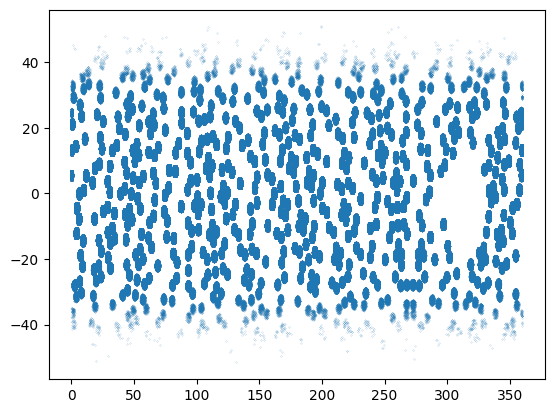

In [14]:
plt.scatter(sssource["eclLambda"], sssource["eclBeta"], s=0.01);

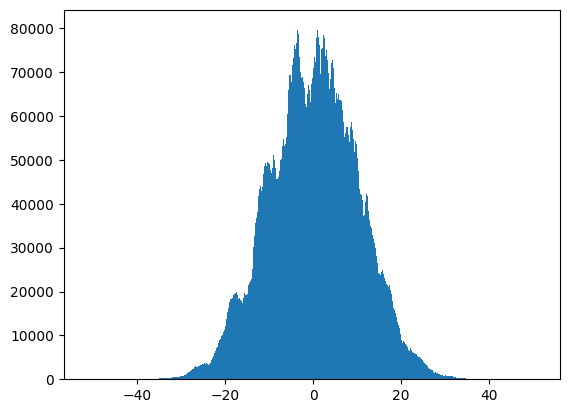

In [15]:
plt.hist(sssource["eclBeta"], bins='fd');

In [19]:
sssource[sssource['ssObjectId'] == 389395]

,diaSourceId,ssObjectId,designation,eclLambda,eclBeta,galLon,galLat,elongation,phaseAngle,topoRange,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail
0,46,389395,2006 SQ427,43.321231,-12.551100,172.567745,-46.421348,-0.353166,-0.527680,-0.383197,...,False,False,False,False,False,False,False,False,False,False
1,5092525,389395,2006 SQ427,95.145562,10.884447,179.374852,9.784899,0.080883,-0.551251,-1.247941,...,False,False,False,False,False,False,False,False,False,False
2,5820022,389395,2006 SQ427,182.442279,16.282310,286.226922,76.290271,-0.593154,0.651970,0.297700,...,False,False,False,False,False,False,False,False,False,False
3,9942505,389395,2006 SQ427,280.557045,-18.916725,354.523968,-18.133259,-0.191896,0.737930,-0.435090,...,False,False,False,False,False,False,False,False,False,False
4,20127463,389395,2006 SQ427,41.955406,2.693196,154.811970,-38.419573,-0.616239,-1.108838,1.315852,...,False,False,False,False,False,False,False,False,False,False
5,31039918,389395,2006 SQ427,135.732229,13.535477,198.270409,46.069627,0.560454,0.505075,-1.198109,...,False,False,False,False,False,False,False,False,False,False
6,35647399,389395,2006 SQ427,170.177418,-2.431102,258.396383,56.411198,-0.840529,0.555797,1.228325,...,False,False,False,False,False,False,False,False,False,False
7,40254880,389395,2006 SQ427,66.137824,10.335845,164.918339,-14.858182,-0.190156,-2.008623,-0.311524,...,False,False,False,False,False,False,False,False,False,False
8,40982377,389395,2006 SQ427,124.437516,-0.015172,205.206405,29.357002,1.435074,-0.502250,0.684734,...,False,False,False,False,False,False,False,False,False,False
9,45347359,389395,2006 SQ427,203.171831,-5.170485,312.660003,48.569583,1.364820,-0.084852,0.120866,...,False,False,False,False,False,False,False,False,False,False


# NearbySSO

In [20]:
%%time
n = len(sssource)
near = columnar_empty(shape=(n + len(mask_extra),), dtype=schema.NearbySSODtype)

near["diaSourceId"][:n] = sssource["diaSourceId"]
near["ssObjectId"][:n] = sssource["ssObjectId"]
near["designation"][:n] = sssource["designation"]
near["ephRa"][:n] = sssource["ephRa"]
near["ephDec"][:n] = sssource["ephDec"]
near["ephOffset"][:n] = sssource["ephOffset"]
near["ephVmag"][:n] = sssource["ephVmag"]
near["ephRateRa"][:n] = sssource["ephRateRa"]
near["ephRateDec"][:n] = sssource["ephRateDec"]

# fill the values for the "nearby" (and not associated) objects
ra, dec = dia["ra"][mask_extra], dia["dec"][mask_extra]
near["diaSourceId"][n:] = dia["diaSourceId"][mask_extra]
fill_sssource(near[n:], ndesig, ra, dec, r=5)
fill_zero_columns(near[n:])

print(len(near))
#pd.DataFrame(near[n-5:n+5])
near[n-5:n+5]

19800000
CPU times: user 352 ms, sys: 98 ms, total: 450 ms
Wall time: 450 ms


,diaSourceId,ssObjectId,designation,ephRa,ephDec,ephOffset,ephVmag,ephRateRa,ephRateDec
0,545198410,485151,2011 DF42,198.027430,-19.696805,0.306774,-0.094802,-0.361977,-0.477416
1,545198415,726772,2011 WS160,199.319109,-18.449295,0.603206,0.166124,2.273888,-1.633666
2,545198442,939559,2000 UU13,199.901681,-18.822319,0.797321,0.592760,0.875929,-1.096075
3,545198465,978025,2006 WF72,199.703549,-19.136843,0.229677,0.143799,-0.757419,-0.018499
4,545198471,755465,2017 QS87,199.294095,-19.607716,0.809241,1.415254,-0.131863,1.018528
5,545198487,26705,2015 AE295,199.173862,-19.201022,4.791831,1.592639,0.555080,0.814965
6,545198501,604586,2006 SK449,198.996310,-18.361505,3.086721,-0.044997,0.960493,-0.505672
7,545198515,823283,1999 FK55,198.412552,-19.555295,0.813711,1.702565,0.493894,0.573605
8,545198530,1422591,2002 PT163,200.904883,-18.647884,4.295480,0.560542,2.705132,1.207921
9,545198539,1863,2004 TS233,200.156323,-19.638511,3.473959,-0.303178,0.397886,-0.177814


This one was associated (and should have an SSSource table entry):

In [23]:
sssource[sssource['diaSourceId'] == near['diaSourceId'][n-1]]

,diaSourceId,ssObjectId,designation,eclLambda,eclBeta,galLon,galLat,elongation,phaseAngle,topoRange,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail
0,545198471,755465,2017 QS87,205.235797,-10.607066,311.211429,42.85004,-1.507965,-0.60528,-0.080811,...,False,False,False,False,False,False,False,False,False,False


This one wasn't associated (and there should be no entry):

In [24]:
sssource[sssource['diaSourceId'] == near['diaSourceId'][n+1]]

,diaSourceId,ssObjectId,designation,eclLambda,eclBeta,galLon,galLat,elongation,phaseAngle,topoRange,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail


# Write out the results

In [25]:
structured_to_parquet(dia,      "diasource.parquet")
structured_to_parquet(sssource, "sssource.parquet")
structured_to_parquet(ssobject, "ssobject.parquet")
structured_to_parquet(near,     "nearbysso.parquet")

diasource.parquet:
  Number of rows:          600000000
  Uncompressed size (GiB): 181.0
  Compressed parquet (GB): 148.83
sssource.parquet:
  Number of rows:          18000000
  Uncompressed size (GiB): 9.2
  Compressed parquet (GB): 7.59
ssobject.parquet:
  Number of rows:          242499
  Uncompressed size (GiB): 0.1
  Compressed parquet (GB): 0.09
nearbysso.parquet:
  Number of rows:          19800000
  Uncompressed size (GiB): 2.1
  Compressed parquet (GB): 0.82


In [27]:
schema.SSObjectDtype.itemsize, schema.SSSourceDtype.itemsize, schema.NearbySSODtype.itemsize

(370, 546, 112)